# Aim:

- This notebook will made a deterministic model of the SEI5R for South Africa and the provinces using PyRoss
- This model does not assume any lockdow scenarios and uses the current value to predict the trajectory of the epidemy


In [61]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [62]:
ForColab = False


## NB: The Pyross is not working in Colab, I will use Github as a platform to share and make amendments to the code


In [63]:
#
# This is here but not working fully in Colab
#
if ForColab:
    !pip install wget
    !pip install git+https://github.com/rajeshrinet/pyross.git
    !pip install git+https://github.com/lukastk/PyRossGeo.git
    import os
    owd = os.getcwd()
    os.chdir('../../')

    import plotly.io as pio
    pio.renderers.default = 'colab'
else:
    print("Working local")

Working local


In [64]:
#
# Import the parameters for the plots
#
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13,
         'axes.labelweight':'bold',
          'legend.fontsize': 13,
         'figure.max_open_warning': 0}
         
plt.rcParams.update(params)

#import matplotlib
#matplotlib.use("cairo")
#import cairo 3 might not need this in the end

In [65]:
from datetime import datetime, timedelta, date

import os
from pathlib import Path
import pickle
from timeit import default_timer as timer
#
# The following is needed for pulling the files from Github
#
import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
    
import pandas as pd
#pd.options.plotting.backend = "plotly"

import numpy as np

from tqdm.notebook import tqdm

from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize,curve_fit

from sklearn.metrics import mean_squared_log_error, mean_squared_error

from PIL import Image

#import chart_studio
#chart_studio.tools.set_config_file(world_readable=False)

#import chart_studio.plotly as ply

#
# Import pyross and pyrossgeo
#

import pyross, pyrossgeo

In [66]:
def plot_model(Data,  ICUHospital, title):

    S  = model.S(Data)
    Ia = model.Ia(Data)
    Is = model.Is(Data)
    R  = model.R(Data)

    InfectedCases = Ia+Is

    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
    fig, ax1 = plt.subplots(1, 1)
    fig.suptitle(title)

    ax1.plot(S, 'tab:blue', label='Susceptible');
    ax1.plot(Ia, 'tab:orange', label='Exposed');
    ax1.plot(Is, 'tab:red', label='Infected');
    ax1.plot(R, 'tab:green', label='Recovered');
    #ax1.plot(InfectedCases, 'tab:purple', label='Hospitalised');
    #ax1.plot(crit, 'tab:brown', label='Critical');
    #ax1.plot(death, 'tab:cyan', label='Deceased');
    #ax1.hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(sus),linestyles='dashed',
    #           label="Mean ICU beds")


    ax1.semilogy()

    ax1.set_xlabel("Days");
    ax1.legend(loc='best');
    ax1.set_ylabel("No of people");
    '''        
    ax2.plot(cases, 'tab:red', label='Cases');    
    ax2.set_xlabel("Days", fontsize=10);
    ax2.semilogy()

    ax3 = ax2.twinx()
    ax3.plot(death, 'tab:cyan', label='Deceased');    
    ax3.set_xlabel("Days", fontsize=10);
    ax3.semilogy()
    '''

    '''
    ax2.set_ylabel("No of population (Cases)", fontsize=10, color='tab:red');
    ax3.set_ylabel("No of population (Fatalities)", fontsize=10, color='tab:cyan');
    '''        

    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),ncol=3, fancybox=True, shadow=True)


# Setting the total poplation for South Africa


In [67]:

NZA = 59156682     # Total number of people in SA


# Getting Covid values for cases in SA for each province 

In [68]:
def get_SA_province(ToUpdateSAProvince):
    
    '''
    This function will get the SA provincial confirmed and cases as function of date from the Uni Pretoria repo
    
    It also has the total that should agree with the reported worldodometer confirmed cases
    
    Usage:
    
        get_SA_province('y') or get_SA_province('n')
    
    Input:
        Take a y or n - whether to update the dataset or not
    
    Output:
        Returns the SA province confirmed dataframe
    '''
    
    import pandas as pd
    import wget
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context

    if ToUpdateSAProvince.lower() =='y':
        
        print("updating data")
        ConfirmedURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
        SAProvinConfirmed = pd.read_csv(wget.download(ConfirmedURL, out ='covid19za_provincial_cumulative_timeline_confirmed.csv'))
        
        DeathURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv"
        SAProvinDead = pd.read_csv(wget.download(DeathURL, out= 'covid19za_provincial_cumulative_timeline_deaths.csv'))
        
        RecoveredURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv"
        SAProvinRecover = pd.read_csv(wget.download(RecoveredURL, out ='covid19za_provincial_cumulative_timeline_recoveries.csv'))
        
    else:
        print("Reading local file... Please check data is uptodate")
        SAProvinConfirmed  = pd.read_csv("covid19za_provincial_cumulative_timeline_confirmed.csv")
        SAProvinDead = pd.read_csv("covid19za_provincial_cumulative_timeline_deaths.csv")
        SAProvinRecover = pd.read_csv("covid19za_provincial_cumulative_timeline_recoveries.csv")
        print(f"Note: File was last updated on {SAProvinConfirmed['date'].values[-1]}")
    #
    # Drop the unwanted column
    #
    if 'YYYYMMDD' in SAProvinConfirmed.columns:
        SAProvinConfirmed.drop(columns='YYYYMMDD', inplace = True)
        SAProvinDead.drop(columns='YYYYMMDD', inplace = True)
        SAProvinRecover.drop(columns='YYYYMMDD', inplace = True)
    #
    # Drop the source of information
    #
    if 'source' in SAProvinConfirmed.columns:
        SAProvinConfirmed.drop(columns='source', inplace = True)
        SAProvinDead.drop(columns='source', inplace = True)
        SAProvinRecover.drop(columns='source', inplace = True)
    #
    # Make the date the index
    #
    SAProvinConfirmed["date"] = pd.to_datetime(SAProvinConfirmed.date, format='%d-%m-%Y')
    SAProvinConfirmed.index = SAProvinConfirmed["date"]
    
    SAProvinDead["date"] = pd.to_datetime(SAProvinDead.date, format='%d-%m-%Y')
    SAProvinDead.index = SAProvinDead["date"]
    
    SAProvinRecover["date"] = pd.to_datetime(SAProvinRecover.date, format='%d-%m-%Y')
    SAProvinRecover.index = SAProvinRecover["date"]
    
    #
    # Deleting the date column now
    #
    SAProvinConfirmed.drop(columns='date', inplace = True)
    SAProvinDead.drop(columns='date', inplace = True)
    SAProvinRecover.drop(columns='date', inplace = True)
    #
    # Renaming the Total column to Confirmed
    #
    SAProvinConfirmed = SAProvinConfirmed.rename(columns={'total': 'ZA'})
    SAProvinDead = SAProvinDead.rename(columns={'total': 'ZA'})
    SAProvinRecover = SAProvinRecover.rename(columns={'total': 'ZA'})
    #
    #
    #

    return(SAProvinConfirmed,SAProvinDead, SAProvinRecover)



In [69]:
#
# Pulling the data from the repo and doing some minor pre-processing
#
ProvinConf, ProvinDead, ProvinRecover = get_SA_province('y') 

ProvinConf.dropna(inplace=True)
ProvinConf = ProvinConf.astype('int64')
ProvinConf.tail()


updating data


,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,ZA
date,,,,,,,,,,,
2020-06-09,6760,391,6546,3255,253,184,122,604,34819,57,52991
2020-06-10,7154,401,7195,3347,257,207,125,657,36021,57,55421
2020-06-11,7868,406,7953,3472,267,228,132,757,37422,63,58568
2020-06-12,8615,435,8781,3573,288,243,138,865,38926,63,61927
2020-06-13,9250,457,9897,3763,309,271,144,977,40605,63,65736


In [70]:
# Since the recovered data was missing for 1 May, we added it manually 

In [71]:
# ProvinRecover[ProvinRecover.index >= '2020-04-28']
'''Eastern Cape	691	254
Free State	118	95
Gauteng	1507	948
KwaZulu Natal	1006	372
Limpopo	34	25
Mpumalanga	35	18
North West	35	16
Northern Cape	18	13
Western Cape	2507	641
Total	5951	2382'''

row = pd.Series({'EC':254,'FS':95,'GP':948,'KZN':372,'LP':25,'MP':18,'NC':13,'NW':16,'WC':641,'UNKNOWN':0,'ZA':2382},name='2020-05-01')


ProvinRecover = ProvinRecover.append(row)


In [72]:
ProvinRecover[ProvinRecover.index == '2020-05-01']

,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,ZA
date,,,,,,,,,,,
2020-05-01,254,95,948,372,25,18,13,16,641,0,2382


In [73]:
#
# Plotting the dataset
#

In [74]:
ProvinConf.drop(columns='UNKNOWN', inplace=True)

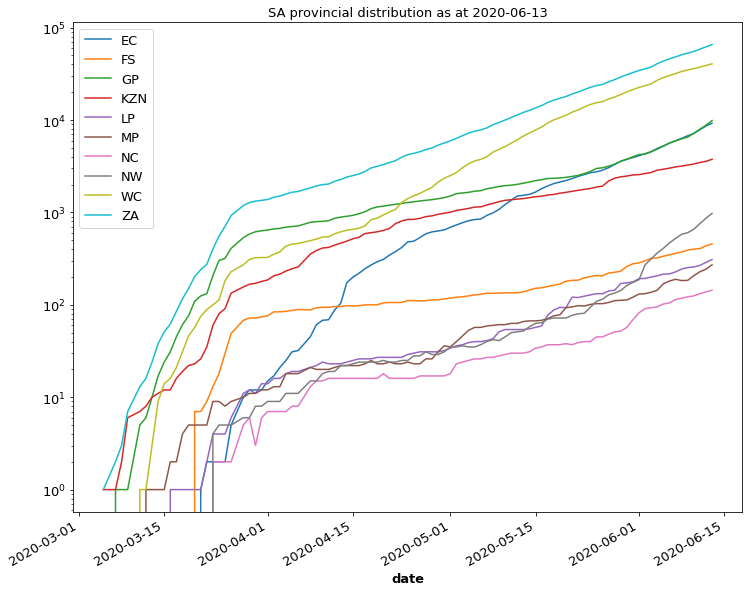

In [75]:


fig = ProvinConf.plot.line(title=f"SA provincial distribution as at {ProvinConf.index[-1].date()}");
fig.semilogy();


## Getting the ZA province population 

In [76]:
def get_SA_Prov_Pop(ToUpdateSAProvince):
    
    '''
    
    This function pulls the population for each provinces
    
    Usage:
    
        get_SA_province('y') or get_SA_province('n')
    
    This function will get the SA provincial population numbers.
    
    Input:
        Take a y or n - whether to update the dataset or not
    
    Output:
        Returns the SA province population dataframe
    '''
    
    import pandas as pd
    import wget
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context

    if ToUpdateSAProvince.lower() =='y':
        
        print("updating data")
        ConfirmedURL = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
        SAProvinPop = pd.read_csv(wget.download(ConfirmedURL, out='za_province_pop.csv'),header=None)
        SAProvinPop.columns = ['Province', 'Pop']
        SAProvinPop['ProvKey'] = ['GP','KZN', 'WC', 'EC','LP', 'MP', 'NW', 'FS', 'NC']
        
    return(SAProvinPop)


updating data


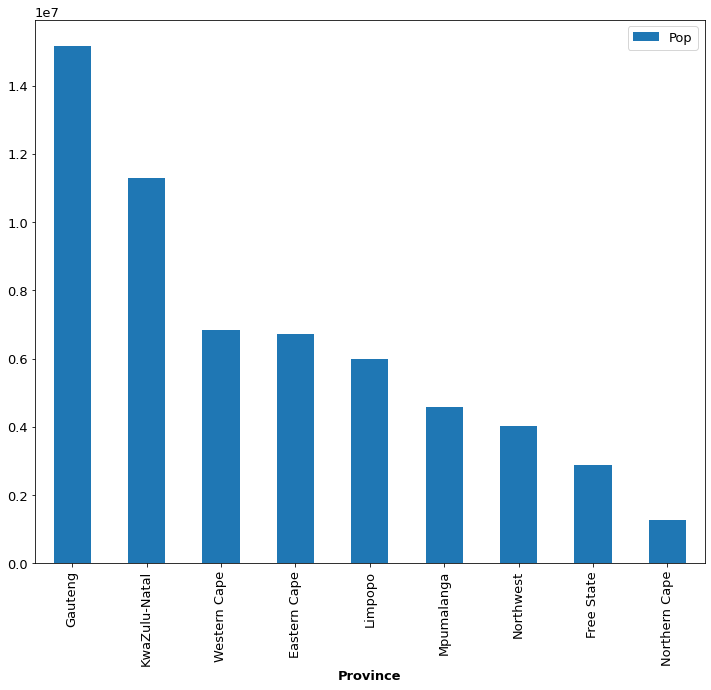

In [77]:
#
# Gettingt the data and doing some plotting 
#
SAProvPop = get_SA_Prov_Pop('y')

SAProvPop.plot(kind='bar',x='Province',y='Pop');

## Getting the Rt calculate values for each province

In [78]:
#
# Taken from Felix updated notebook
#
def get_Rt_lm(DFSeries):
    '''
    This function will calculate the value of Rt for a series.
    In order to calculate R0 we can adapt this 
    https://en.wikipedia.org/wiki/Basic_reproduction_number#Estimation_methods

    Reminder: Rt = R0 when no intervention has been applied and there is mixing
    
    usage get_Rt(pandas_series)
    
    Input:
        Take in a pandas series with time and value
    Output:
        Return the value of R0
    In addition we use a different fitting approach than above
    '''
    import numpy as np
    from lmfit import minimize, Parameters, report_fit # added by [NO]
    
    params = Parameters()
    params.add('a', value=0.)
    params.add('b', value=0.)
    def get_residuals(params, x, data):
        a=params['a'].value
        b=params['b'].value
        model = a * np.exp(b*x)
        return data - model
    
    x = np.arange(len(DFSeries))
    data = list(DFSeries.values)
    out = minimize(get_residuals,params, args = (x,data))
    a = out.params['a'].value
    b = out.params['b'].value
    sigma_b = out.params['b'].stderr
    
    #a = LogisticFit[0][0]
    #b = LogisticFit[0][1] # This is also known as K from description in Wikipedia
    #
    # The dooubling rate is given by T_d
    #
    T_d = np.log(2)/b 
    #
    # We will use the imperial value for tau, this can change later
    #
    tau = 5.1 
    sigma_Rt = (np.exp(b*tau)) * (np.sinh(tau*sigma_b)) #obtaining error for Rt based on error in b
    Rt = np.mean(np.exp(b*tau))
    
    #report_fit(out) # added by [NO]
    
    return (Rt , sigma_Rt, T_d)

In [79]:
#
# To updated Rt based on the exponential fit parameters we run this function after updating the dataframes
#
Recent_prov_Rt = {i: get_Rt_lm(ProvinConf.tail(14)[i]) for i in ProvinConf.columns}

Recent_prov_Rt

{'EC': (1.4151041902035963, 0.010773256778496523, 10.181504714115462),
 'FS': (1.2072273688481452, 0.005670834165669648, 18.77088133264932),
 'GP': (1.4446230887899545, 0.023785915067252368, 9.610073461693176),
 'KZN': (1.1652214281958793, 0.004289402384452316, 23.118333376645868),
 'LP': (1.228486121314909, 0.010944641204900657, 17.178567828071515),
 'MP': (1.3574108151152149, 0.025039115418911642, 11.56836621275822),
 'NC': (1.272557964290185, 0.014745705077952411, 14.666493778107576),
 'NW': (1.7967991583026113, 0.04069030455205855, 6.0324392145498145),
 'WC': (1.2814283512187352, 0.010789035322562675, 14.255653020266502),
 'ZA': (1.3133573880587195, 0.0054462131861441705, 12.96853430165613)}

In [80]:
#
# Using the Rt around the date we starting out forecasting
#

df = ProvinConf.loc[(ProvinConf.index >= '2020-04-23') & (ProvinConf.index < '2020-05-08')]

#df.drop(columns='UNKNOWN', inplace = True)

Recent_prov_RtConf = {i: get_Rt_lm(df.head(14)[i]) for i in df.columns}


Recent_prov_RtConf

RtDfConfirmed = pd.DataFrame(Recent_prov_RtConf).T

RtDfConfirmed.columns = ['Rt','RtSigma', 'DoublingTime']

RtDfConfirmed

,Rt,RtSigma,DoublingTime
EC,1.293895,0.014656,13.719981
FS,1.078229,0.005444,46.933607
GP,1.144063,0.006131,26.266179
KZN,1.157276,0.003914,24.201292
LP,1.164512,0.011826,23.210828
MP,1.559735,0.041771,7.952581
NC,1.273062,0.035506,14.642439
NW,1.161857,0.018329,23.563986
WC,1.551838,0.014404,8.044443
ZA,1.321558,0.006733,12.679011


In [81]:
try:
    #
    # In case have already removed this column 
    #
    ProvinDead = ProvinDead.drop(['UNKNOWN','MP','NC','LP','NW'],axis = 1)
except:
    pass

Recent_prov_Rt = {i: get_Rt_lm(ProvinDead.tail(14)[i]) for i in ProvinDead.columns}

Recent_prov_Rt

{'EC': (1.5813833704837184, 0.057673669297187764, 7.713398441792837),
 'FS': (1.0517086008326744, 0.01256017526097862, 70.11752169272685),
 'GP': (1.4249581713774537, 0.05374090645187441, 9.982001655912025),
 'KZN': (1.1016012629257965, 0.010097626231061549, 36.53239687686223),
 'WC': (1.3334391824260703, 0.011763319627899739, 12.284656425206075),
 'ZA': (1.3462526946689317, 0.005064659137703299, 11.889518884326346)}

In [82]:
#
# Using the Rt around the date we starting out forecasting
#

df = ProvinDead.loc[(ProvinDead.index >= '2020-04-23') & (ProvinDead.index < '2020-05-08')]

#df.drop(columns='UNKNOWN', inplace = True)

Recent_prov_Rt = {i: get_Rt_lm(df.head(14)[i]) for i in df.columns}


Recent_prov_Rt

RtDfDead = pd.DataFrame(Recent_prov_Rt).T

RtDfDead.columns = ['Rt','RtSigma', 'DoublingTime']

In [83]:
RtDfDead

,Rt,RtSigma,DoublingTime
EC,1.485899,0.056846,8.926450
FS,1.101174,0.019496,36.679448
GP,1.367263,0.035051,11.300926
KZN,1.125934,0.007401,29.803303
WC,1.500502,0.026462,8.711321
ZA,1.339801,0.012056,12.084780


# SEAI8R

- The SEAI8R model is a variation of the SIR model with inclusion of extra compartments such as the Exposed (E), Activated (A) compartment.

- The activated compartment holds the population of cases that are asymptomatic and infectious.


## Description of the model: 


![Screenshot_2020-05-13_at_13.54.00](https://gitlab.com/camsofties/covid19//uploads/55279e434788919018151d4793bb11f0/Screenshot_2020-05-13_at_13.54.00.png)



The following parameters are used in this model:

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), 
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals), 
* $\gamma_\mathrm{E}$ (rate of exposed -> activated), 
* $\gamma_\mathrm{A}$ (rate of activated -> infected, symptomatic or asymptomatic)
* $\mathrm{hh}$ (rate of infected -> hospitalised)



# Doing a more complex model now pyross.deterministic.SEAI8R for ZA


## 1 - Define model

In [84]:
def contactMatrix(t):   
    return np.identity(M)

# Below this cell can be very computer intensive 

### Here we, will create and array with the parameters from an ensemble similar to what we did for the National model.

#### The table below are the values that we have used in our finaldocument

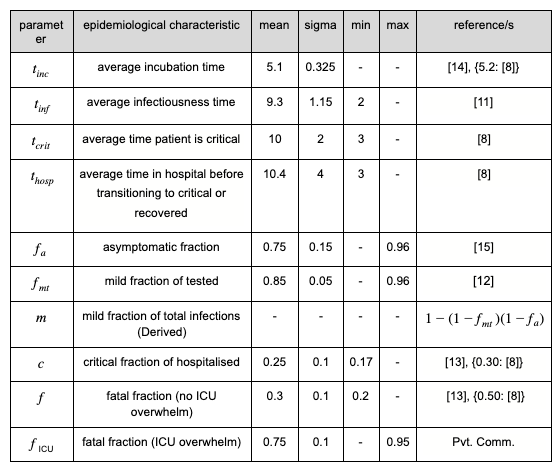

# Model parameter Set up

In [85]:
def ToPlot(ArrayToPlot, TimeArray, DfDead, DateToStart, Ni, title, OutFile):
    '''
    
    This function will take the prediction array and produce the plots similar to the ones we have used in our report
    
    Input:
        ArrayToPlot - this is the array returned from the modelling that hild the varous compartment populations
        TimeArray - array holding the time indices that was used for the prediction
        DfDead - dataframe containing the dead cases for plotting over our fatalities
        DateToStart - date to start plotting fatalities
        title - the title of your plot
    Output:
        Return NoN
    '''
    
    S = ArrayToPlot[:,:,0]     # Susceptible compartment
    E = ArrayToPlot[:,:,1]     # Exposed compartment
    A = ArrayToPlot[:,:,2]     # Activated compartemtn time series
    Ia = ArrayToPlot[:,:,3]    # asymptomatic time series
    Is = ArrayToPlot[:,:,4]    # symptomatic time series
    Ih = ArrayToPlot[:,:,5]    # hospitalised time series
    Ic = ArrayToPlot[:,:,6]    # Critical/ICU time series
    Im = ArrayToPlot[:,:,7]    # mortality time series
    R = ArrayToPlot[:,:,8]     # Removed population time series and is given by R = N(t) - (S + E + A+ Ia + Is + Ih + Ic)

    # cases = (inf + rec + hosp + crit + death) 
    
    #TotalCases = (Ia + Is + Ih + Ic + Im + R + E + A)
    TotalCases = Ni - S
    #
    # Plan is to set this as proper date if needed
    #
    #StartDate = datetime.strptime(DateToStart, "%Y-%m-%d")
    #datelist = pd.date_range(StartDate, periods=Tf).tolist()

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, dpi=72)

    #
    # set uniform characteristics for axes
    #
    for idx, axis in enumerate([ax1, ax2, ax3, ax4]):
        axis.set_ylim(ymin=1, ymax=Ni*1.2)
        axis.set_xlim(0, 365)
        axis.set_yscale('log')
        axis.tick_params(axis='y', labelsize=15);
        axis.hlines([1e+03, 1e+04, 1e+05, 1e+06], xmin=0, xmax=Tf, linestyles='dotted', alpha = 0.6);

    #
    # Doing the plot now
    #
    median_death_list = []
    median_hosp_list = []
    median_critical_list = []
    median_cases_list = []
    
    for i in range(len(ArrayToPlot)):
        ax1.plot(TimeArray, Ic[i,:], 'tab:orange', alpha=0.1, label='Ic - Critical/ICU')
        
        ax2.plot(TimeArray, Im[i,:], 'tab:red', alpha=0.1, label='Im - Fatality')
        ax2.plot(np.median(Im, axis=0), color = 'white', linewidth = '2')
        
        ax3.plot(TimeArray, Ih[i,:], 'dodgerblue', alpha=0.1, label='Ih - Hospitalised')
        
        ax4.plot(TimeArray, TotalCases[i,:], 'tab:blue', alpha=0.1, label='Cases - Total Cases')
        ax4.plot(np.median(TotalCases , axis=0), color = 'white', linewidth = '2')
    #
    # To plot the current dead cases, include the following, by passing this dataframe too
    #
    ax2.plot(DfDead[DfDead.index >= DateToStart].values, 'k', lw=3)

    fig.suptitle(title, fontsize=16)

    ax1.set_title("Individuals in Critical State")
    ax2.set_title("Fatalities")
    ax3.set_title("Individuals in Hospital")
    ax4.set_title(("Total Cases"))


    ax1.set_ylabel('Populations')
    ax3.set_ylabel('Populations')
    ax3.set_xlabel(f"Time [No. days from {DateToStart}]")
    ax4.set_xlabel(f"Time [No. days from {DateToStart}]")
    
    fig.savefig(OutFile)
    
    return()

In [86]:
def plot_hist(comp, colour_to_use, ToPredict, title="Histogram and KDE through scenario ensemble", days = [61,91,153]):
    '''
    This funtion is an adaptation of Richard's histogram plot using KDE
    
    Input:
        comp - Array holding the data to plot
        
    '''
    # plot histogram for specified compartment on various key dates
    # set up the axes, titles, styles, etc
    fig, axes = plt.subplots(2, 2, dpi=72)
    ((ax1, ax2), (ax3, ax4)) = axes
    fig.suptitle(title, fontsize=14)
    ax1.set_title(ToPredict[0].strftime('%d %B'))
    ax2.set_title(ToPredict[1].strftime('%d %B'))
    ax3.set_title(ToPredict[2].strftime('%d %B'))
    ax4.set_title("Maximum")
    plt.tight_layout()

    # set uniform characteristics for axes
    for idx, axis in enumerate([ax1, ax2, ax3, ax4]):
        #print(idx, axis)
        axis.set_yscale('log')
        axis.set_xscale("log")
        axis.tick_params(axis='y', labelsize=12);

        if idx == 3:
            hist_data = comp.max(1)
        else:
            hist_data = comp[:,int(days[idx])]

        ax1.set_ylabel("density", fontsize=10);

        MAX=np.max(hist_data)
        MIN=np.min(hist_data)
        bins = np.logspace(np.log10(MIN), np.log10(MAX), 30)
        x_d = np.linspace(MIN, MAX, hist_data.shape[0])

        axis.hist(hist_data, bins=bins, density=True, histtype='step', linewidth = '2', color=colour_to_use)#, alpha=0.5, log=True)

        #percentiles
        axis.axvline(np.percentile(hist_data, 50), color='red', linewidth = '2', linestyle='solid', alpha=0.85) #ax2.axvline(np.median(h_data), color='g')
        #axis.axvline(np.percentile(hist_data, 84), color='blue', linestyle='dashed', alpha=0.5)
        #axis.axvline(np.percentile(hist_data, 16), color='red', linestyle='dashed', alpha=0.5)
        axis.axvline(np.percentile(hist_data, 97.5), color='blue', linestyle='dashed', alpha=0.75)
        axis.axvline(np.percentile(hist_data, 2.5), color='blue', linestyle='dashed', alpha=0.75)
    
    
    return()


In [87]:
#
# Model parameters set up, each parameter names will be a column and the number of ensemble will be the rows
#
def ToEnsemble(NoIteration, Rt_initial):
    '''
    This function will create and ensemble of paramters that will be stired in a dataframe and passed onto 
    the modelling
    
    Input:
        NoIteration - no of sample to generate
        Rt_initial - initial value of Rt to use 
        
    '''
    alpha  = []
    Rt     = [] ; tinf   = [] ; beta   = []
    t_incu = []
    gE     = []; gA     = []; gIa    = []; gIs    = []
    fsa    = []; fh     = []
    gIh    = []; gIc    = []; gIsp   = []; gIhp   = []; gIcp   = []

    for i in range(NoIteration):

        alpha_tmp = np.minimum(0.96, np.random.normal(0.75, 0.15)) # fraction of infected who are asymptomatic, fa
        alpha.append(alpha_tmp)                         

        #beta  = 0.15                                         # Uncomment to use infection rate for South Africa from 
                                                              # https://www.medrxiv.org/content/10.1101/2020.04.18.20070771v2
                                                              # beta = Rt/tinf
        #Rt_tmp = Rt_initial*np.random.normal(1.35, 0.15)
        #Rt_tmp = np.maximum(0.65, Rt_initial*np.random.normal(1.0, 0.2))
        Rt_tmp = np.maximum(Rt_initial,np.random.normal(1.35, 0.15))
        Rt.append(Rt_tmp)                                     # using the value we used in our original model

        tinf_tmp = np.maximum(2, np.random.normal(9.3, 1.15)) # t_infect = np.maximum(3,np.random.normal(9.3, 1.15)) NB - changed to range over which density 
                                                              # of infectiousness was 1%
        tinf.append(tinf_tmp)                                 # infectious time
        beta.append(Rt_tmp/tinf_tmp)
        
        t_incu_tmp = np.random.normal(5.1, 0.325)             # average incubation period: "median incubation period was estimated to be 5.1 days 
                                                              # (95% CI, 4.5 to 5.8 days) https://www.acpjournals.org/doi/10.7326/M20-0504                           
        t_incu.append(t_incu_tmp)
        gE.append(1./t_incu_tmp)                              # rate of removal of Exposed, aka 1/t_incu 

        gA_tmp = np.random.normal(2., 0.5)                    # rate of removal of Activated, i.e time from onset of infectiousness to onset of symptoms
        gA.append(1./gA_tmp) 
        
        gIa_tmp = np.maximum(6, np.random.normal(2, 3))       # rate of removal of asymptomatic infectives, based from
                                                              # https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2766237
        gIa.append(1./gIa_tmp)                      
        
        gIs_tmp = tinf_tmp                                    # rate of removal of symptomatic infectives, linked to t_inf
        gIs.append(1./gIs_tmp)                      


        fsa    = 1.                                           # the self-isolation parameter   
        fh     = 0.2                                          # fraction by which hospitalised individuals are isolated

        gIh_tmp = np.maximum(3, np.random.normal(10.4, 4)) # rate of removal for hospitalised individuals, related to t_hosp
        gIh.append(1./gIh_tmp)                     
        
        gIc_tmp = np.maximum(3, np.random.normal(10, 2))   # related to t_cric
        gIc.append(1./gIc_tmp)                             # rate of removal for idividuals in intensive care
    
        #
        # The buffer is basicaly the compartment prior to recovered
        # 
        
        gIsp_tmp = 12.
        gIsp.append(1./gIsp_tmp)                   # rate of removal from symptomatic individuals towards buffer

        gIhp_tmp = np.maximum(3, np.random.normal(10.4, 4))
        gIhp.append(1./gIhp_tmp)                   # rate of removal from hospitalised individuals towards buffer

        gIcp_tmp = np.maximum(3, np.random.normal(10, 2))
        gIcp.append(1./gIcp_tmp)                   # rate of removal from ICU individuals towards buffer


    ModelParamDf = pd.DataFrame({'alpha':alpha,'Rt': Rt, 'tinf': tinf, 'beta':beta, 't_incu':t_incu,
                                 'gE': gE, 'gA': gA, 'gIa':gIa, 'gIs':gIs,'fsa':fsa, 
                                 'fh':fh, 'gIh':gIh,'gIc':gIc, 'gIsp':gIsp, 'gIhp':gIhp, 
                                 'gIcp':gIcp}, 
                                columns = ['alpha', 'Rt', 'tinf', 'beta', 't_incu', 
                                           'gE', 'gA', 'gIa', 'gIs', 'fsa', 'fh', 'gIh',
                                           'gIc', 'gIsp', 'gIhp', 'gIcp'])
    return(ModelParamDf)

In [88]:
## Will make a function to call the model

def MyModel(NoIteration, ParamDf, NoConfirmed, NoRecovered, NoDead, M,  Tf, Nf, Ni):
    NZA = 59156682 
    '''
    This function is used to instantiate the model again for ensemble
    
    Input:
        NoIteration - Number of iterations to run (which should be <= Number of iteration used to generate ensemble)
        ParamDf - dataframe containing the ensemble paramters
        M, Tf, Nf, Ni - parameters explained earlier 
    Output:
        trajectories_s - series for the prediction for each compartment 
        trajectories_time - time series from prediction
    
    '''

    NoCompartment = 9                                    # Total number of compartments we have in our model
    trajectories_s = np.zeros([Nums,Nf,9*M],dtype=float) # setting array to hold our results


    for i in range(NoIteration):
        if i%100 == 99: 
            #print('Got to run: ', i+1)
            print('Ran {0} simulation out of {1}'.format(i+1,NoIteration),end='\r')
        #
        # intantiate model
        #

        A_0   = np.zeros((M))

        #
        #Ia_0  initial asymptomatic cases
        #

        frac_asymptomatic = ParamDf['alpha'].values[i] # 5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/

        #
        # total cases - recovered: 5951 - 2498
        #
        n_tested_active   = NoConfirmed - NoRecovered
        #n_tested_active   = ProvinConf[ProvinConf.index == DateToStart]['ZAConfirmed'].values[0]- \
        #                    ProvinRecover[ProvinRecover.index == DateToStart]['ZARecovered'].values[0]

        Ia_0              = (n_tested_active * (1/(1-frac_asymptomatic)))*np.ones((M)) 

        #
        # initial symptomatic cases
        #
        Is_0  = NoConfirmed*np.ones((M))
        Isp_0 = np.zeros((M))

        #
        # initial hospitalised cases
        #
        Ih_0  = 411*np.ones((M))*Ni/NZA                       # this is national number as at 2 May 2020 for ZA            
        Ihp_0 = np.zeros((M))
        
        #
        # initial icu patients
        #
        NoICU = 35 *(Ni/6844272)                              # Number of patients in ICU for WC as on 1 May 35 in ICU
        Ic_0  = NoICU*np.ones((M))                
        Icp_0 = np.zeros((M))
        
        #
        # initial mortality cases
        #
        Im_0  = NoDead*np.ones((M))

        #
        #
        #
        
        #E_0   = Ia_0 * 1.7                     # (R_t^(time from infection to test)/t_inf ~ 2)*n_infected
        E_0   = ((Ia_0+Is_0)*ParamDf['Rt'].values[i]**2)*np.ones((M))   # (R_t^(time from infection to test)/t_inf ~ 2)*n_infected

        #
        # assume no removed individuals
        #
        #n_recovered = (n_total_cases - n_tested_active) * (1/(1-frac_asymptomatic))
        R_0   = (NoConfirmed - n_tested_active)*\
                (1/(1-frac_asymptomatic))*np.ones(M)

        S_0   = Ni - (E_0 + A_0 + Ia_0 + Is_0 + Isp_0+ Icp_0+ Ihp_0 + Ih_0 + Ic_0 + Im_0  + R_0)

        #
        # The following parameters are vry critical to the model
        #

        sa   = 0.02*np.ones(M)      # daily arrival of new susceptibles - (birth rate around 2%)
                                    # sa can also be the rate of additional/removal of population by birth etc
        
        #frac_asymptomatic = #np.minimum(0.96, np.random.normal(0.75, 0.15)) #5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
        frac_tested_mild = np.minimum(0.96, np.random.normal(0.8, 0.05)) # ratio of tested infections that are mild. [CCDC]
        #hh   = ((1.-frac_asymptomatic) * (1 - 0.96))*np.ones(M)
        
        
        #hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital, (1 - m_a)
        hh   = (1.-((1.-frac_asymptomatic) * (1 - frac_tested_mild)))*np.ones(M)
        
        cc   = 0.25*np.ones(M)      # fraction sent to ICU from hospitalised, this has an impact on the dip was seeing in the critical state,c_a
        #cc   = np.minimum(0.17, np.random.normal(0.25, 0.1))*np.ones(M)
        
        #mm   = 0.75*np.ones(M)        # mortality rate in ICU, aka IFR !!!, f_a
        mm   = np.minimum(0.2, np.random.normal(0.3, 0.1))*np.ones(M)
        
        parameters = {'alpha':ParamDf['alpha'].values[i],
                      'beta' :ParamDf['beta'].values[i], 
                      'gIa'  :ParamDf['gIa'].values[i],
                      'gIs'  :ParamDf['gIs'].values[i],
                      'gIh'  :ParamDf['gIh'].values[i],
                      'gIc'  :ParamDf['gIc'].values[i],
                      'gE'   :ParamDf['gE'].values[i],
                      'gA'   :ParamDf['gA'].values[i],
                      'fsa'  :ParamDf['fsa'].values[i],
                      'fh'   :ParamDf['fh'].values[i], 
                      'gIsp' :ParamDf['gIsp'].values[i], 
                      'gIcp' :ParamDf['gIcp'].values[i], 
                      'gIhp' :ParamDf['gIhp'].values[i],
                      'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
        model = pyross.deterministic.SEAI5R(parameters, M, Ni)
        data  = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, contactMatrix, Tf, Nf)
        trajectories_s[i] = data['X']
    
    trajectories_time =  data['t']
    
    return(trajectories_s, trajectories_time)

## Start running from here if nothing changed in functions


In [89]:
M     = 1                             # Number of compartments of individual for each class,
                                      # the SIR model has no age structure for now
Ni    = NZA*np.ones(M)                # Initial number in each compartment and class
N     = np.sum(Ni)                    # and the total population is the size of this age group

DateToStart = '2020-05-01'            # Date to start the prediction since recovered value missing

Tf = 365                              # reference trajectory is 240 days long
Nf = 600                              #         



In [90]:
#
# This is testing for National values, change Rt initial if required
# 
Nums = 1000


In [91]:
#ParamDf = ToEnsemble(Nums, Rt_initial=2.4)

#ParamDf.head()

#ParamDf.Rt.plot(kind='hist',bins=25);
#plt.xlabel("Rt values")

# Now running everything

Enter province name of [ZA] from above names ['GP' 'KZN' 'WC' 'EC' 'LP' 'MP' 'NW' 'FS' 'NC'] ZA


Total population in ZA = 59,156,682
Current Rt value using past 14 days data is 1.32
count    1000.000000
mean        1.402613
std         0.104190
min         1.321558
25%         1.321558
50%         1.353096
75%         1.462070
max         1.832506
Name: Rt, dtype: float64

### Running prediction model now ###



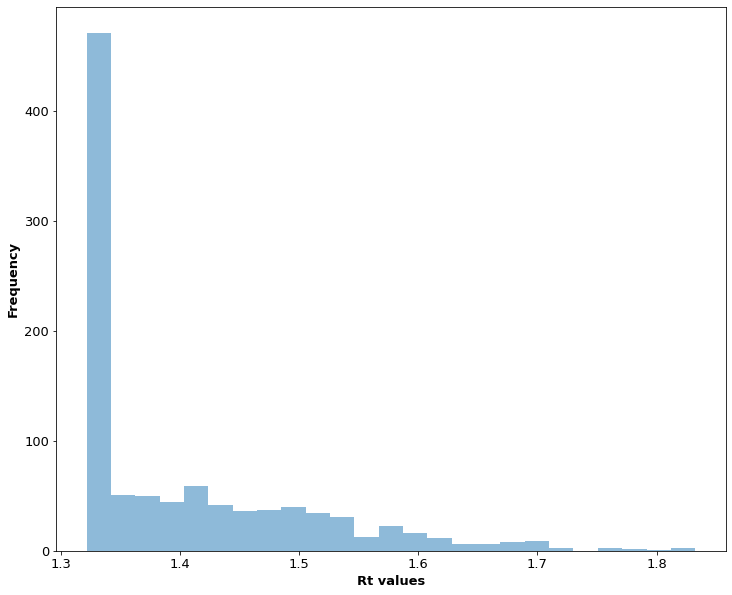

In [93]:
province = input(f"Enter province name of [ZA] from above names {SAProvPop.ProvKey.unique()}") 
#
# First calculate ParamDf, e.g. using Rt for WC
#
ParamDf = ToEnsemble(Nums, Recent_prov_RtConf[province][0])
#
# Get the number of cases at the date we start our prediction
#
ConfirmedVal = ProvinConf[ProvinConf.index == DateToStart][province].values[0]
RecoveredVal = ProvinRecover[ProvinRecover.index == DateToStart][province].values[0]
DeadVal = ProvinDead[ProvinDead.index == DateToStart][province].values[0]
#
# Create a dataframe for the dead case for plotting
#
DeadDf = pd.DataFrame(ProvinDead[province])

if province == 'ZA':
    Ni = np.array([NZA]) # SAProvPop.Pop.sum() - 58820020
else:
    Ni = SAProvPop[SAProvPop['ProvKey'] == province]['Pop'].values

print(f"Total population in {province} = {Ni[0]:,d}")

print(f"Current Rt value using past 14 days data is {Recent_prov_RtConf[province][0]:.3}")

print(ParamDf.Rt.describe())

ParamDf.Rt.plot(kind='hist',bins=25, alpha=0.5); plt.xlabel("Rt values");

#
# Now runing the model prediction
#

print("\n### Running prediction model now ###\n")

MyPredict, MyPredictTime = MyModel(Nums, ParamDf, ConfirmedVal, RecoveredVal, DeadVal, M,  Tf, Nf, Ni)

#CriticalDf = pd.DataFrame(MyPredict[:,:,6].T)
#CriticalDf.loc[0:].plot(color='r',alpha=0.1, logy=True,legend=False);

()

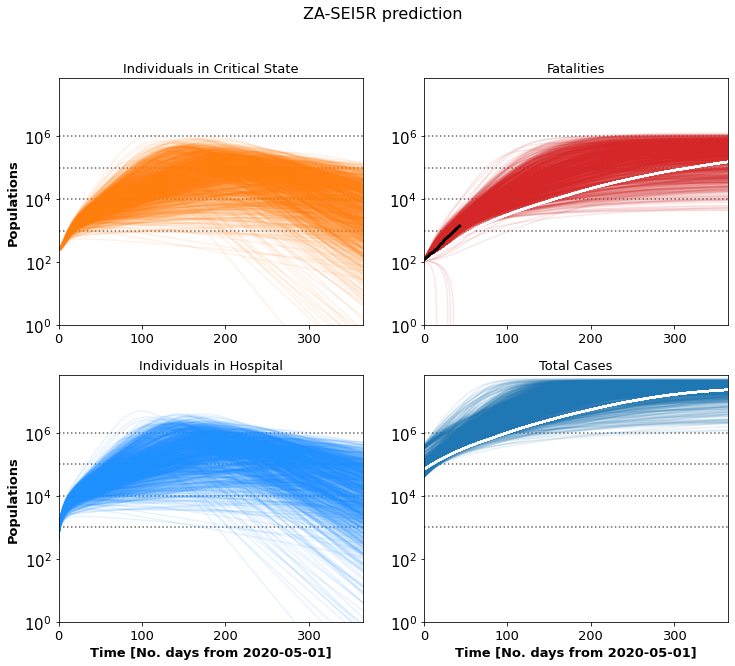

In [94]:
#
# Plotting the results
#

ToPlot(MyPredict, MyPredictTime, DeadDf, DateToStart, Ni, province+"-SEI5R prediction", "ZA.png")
#plt.savefig("PySEI5R_Province_"+province+"_SEI5R_prediction.png")

# Doing the KDE histogram plot 

## The histogram will be plotted for 15 June, 15 July, 15 August and also the total for the year

In [42]:
#
# This is what we need for infectious - need to confirm with Rochard
# SwapAxes[:,compartment_labels.index(show_labels[0]),:]+SwapAxes[:,compartment_labels.index(show_labels[1]),:]
#

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:433: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:433: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


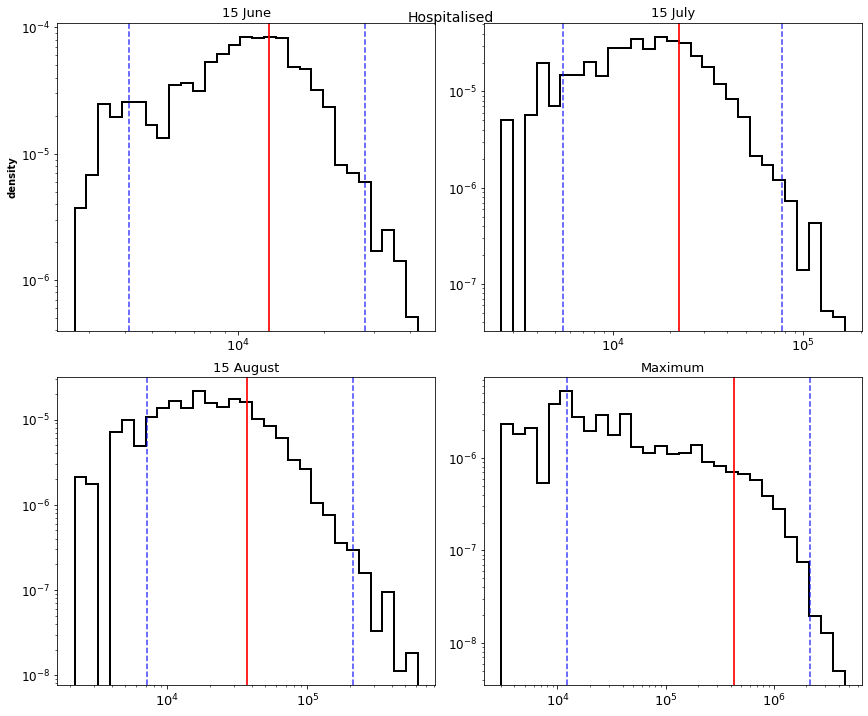

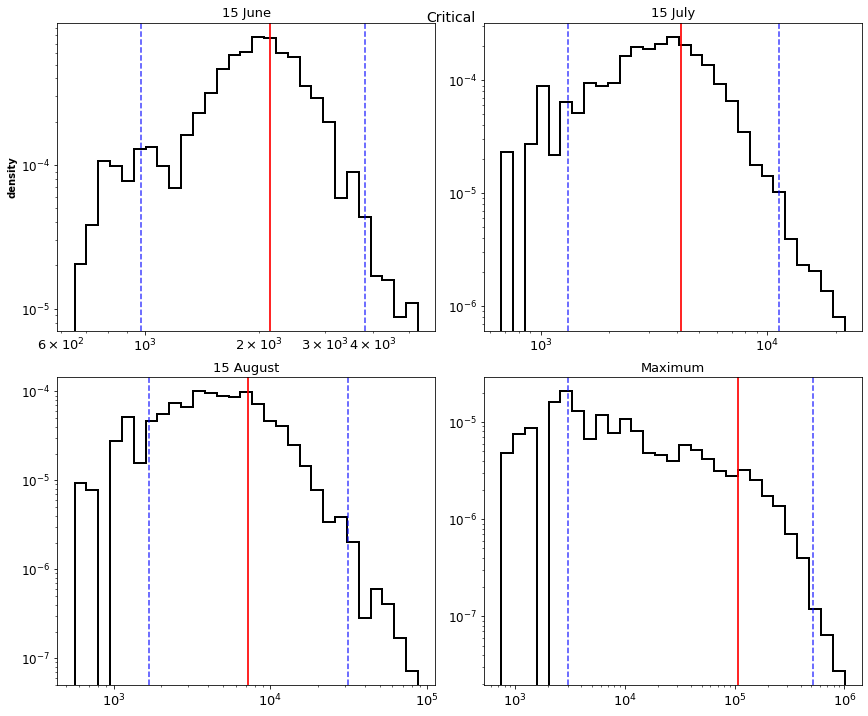

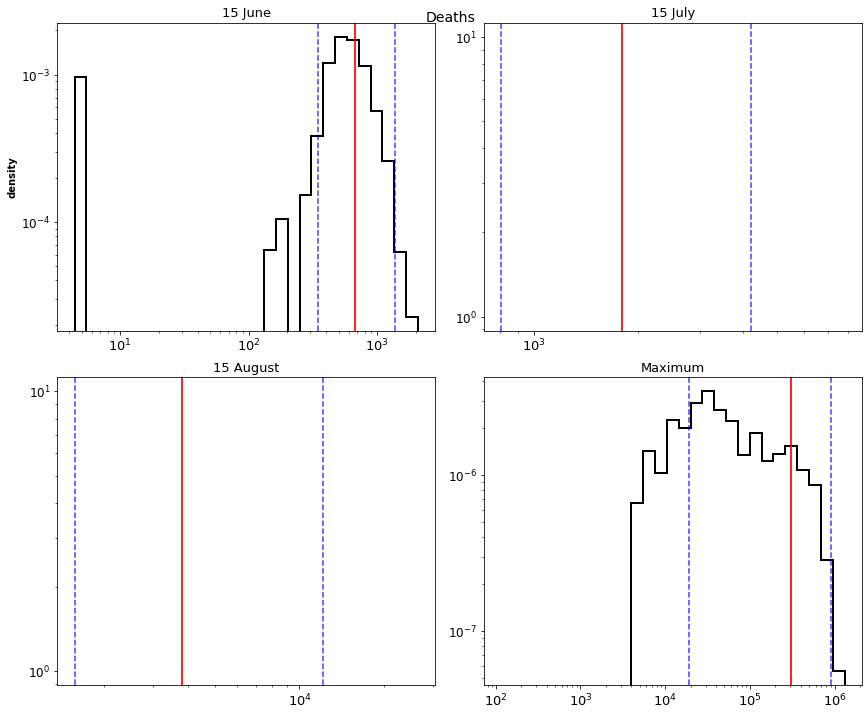

In [43]:
#
# Swap my axes to be in-line as Richard's function requirements
#
SwapAxes = np.swapaxes(MyPredict,1,2)

#SwapAxes.shape

#is_arr = np.empty([N_RUNS, sol.y.shape[0], sol.y.shape[1]])

colorvec = ['orange','red','dodgerblue','blue']

#for idx, sol in enumerate(i_scenarios):
#    is_arr[idx,:,:] = sol.y
# My SwapAxes array is already in this shape of is_arr

#
# days of evaluation should correspond to [1 June, 1 July, 1 September]
#

first_date = datetime.strptime(DateToStart, '%Y-%m-%d')
last_date0 = datetime.strptime('2020-6-15', '%Y-%m-%d')
last_date1 = datetime.strptime('2020-7-15', '%Y-%m-%d')
last_date2 = datetime.strptime('2020-8-15', '%Y-%m-%d') 
DatesToPredict = [last_date0 ,last_date1, last_date2]

eval_days = [(last_date0 - first_date).days,(last_date1 - first_date).days,(last_date2 - first_date).days]

#
# In our model we get the folllowing: S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, R
#
# S = ArrayToPlot[:,:,0]
# E = ArrayToPlot[:,:,1]
# A = ArrayToPlot[:,:,2]
# Ia = ArrayToPlot[:,:,3]
# Is = ArrayToPlot[:,:,4]
# Ih = ArrayToPlot[:,:,5]
# Ic = ArrayToPlot[:,:,6]
# Im = ArrayToPlot[:,:,7]
# R = ArrayToPlot[:,:,8]

    
#compartment_labels = ['Susceptible', 'Exposed', 'Infectious', 'Recovered', 'Hospitalised', 'Critical', 'Deaths']
compartment_labels = ['Susceptible', 'Exposed', 'Activated', 'Infected Asymptomatic', 'Infected Symptomatic', 'Hospitalised', 'Critical', 'Deaths', 'Recovered']
show_labels = ['Hospitalised', 'Critical', 'Deaths']

#for idx, scen in enumerate(np.rollaxis(is_arr[:,[compartment_labels.index(show_labels[0]), 
#                                                 compartment_labels.index(show_labels[1]), 
#                                                 compartment_labels.index(show_labels[2]), 
#                                                 compartment_labels.index(show_labels[3])],:], 1)):    
for idx, scen in enumerate(np.rollaxis(SwapAxes[:,[compartment_labels.index(show_labels[0]), 
                                                 compartment_labels.index(show_labels[1]), 
                                                 compartment_labels.index(show_labels[2])],:], 1)): 
    colour_plot = 'k' #colorvec[idx-1]
    
    plot_hist(scen, colour_plot, DatesToPredict,  title = show_labels[idx], days=eval_days)

    plt.savefig("ZA_Temp_KDE"+show_labels[idx]+".png")
# for reference: sus, exp, inf, rec, hosp, crit, death = solution.y
# cases = (inf + rec + hosp + crit + death) 

In [44]:
print(f"Death as as at {ProvinDead.index[-1].date()}: {ProvinDead[province].iloc[-1]}")

Death as as at 2020-06-10: 1210


In [45]:
ToLoopAll = False

Nums = 1000

#
# Which Rt values to use, the confirmed cases of the deadth
#
Recent_prov_Rt = Recent_prov_RtConf


## The cell below is for looping into all the provinces

In [46]:

if ToLoopAll:

    for province  in SAProvPop.ProvKey.unique():
        
        #
        # First calculate ParamDf, e.g. using Rt for WC
        #
        ParamDf = ToEnsemble(Nums, Recent_prov_Rt[province][0])
        #
        # Get the number of cases at the date we start our prediction
        #
        ConfirmedVal = ProvinConf[ProvinConf.index == DateToStart][province].values[0]
        RecoveredVal = ProvinRecover[ProvinRecover.index == DateToStart][province].values[0]
        DeadVal = ProvinDead[ProvinDead.index == DateToStart][province].values[0]
        #
        # Create a dataframe for the dead case for plotting
        #
        DeadDf = pd.DataFrame(ProvinDead[province])

        if province == 'ZA':
            Ni = np.array([NZA]) # SAProvPop.Pop.sum() - 58820020
        else:
            Ni = SAProvPop[SAProvPop['ProvKey'] == province]['Pop'].values

        print(f"Total population in {province} = {Ni[0]:,d}")

        print(f"Current Rt value using past 14 days data is {Recent_prov_Rt[province][0]:.3}")

        #print(ParamDf.Rt.describe())
                
        #
        plt.figure();
        ParamDf.Rt.plot(kind='hist',bins=25, alpha=0.5);
        plt.xlabel("Rt values");
        plt.savefig("PySEI5R_Province_"+province+"_SEI5R_histo.png")        

        #
        # Now runing the model prediction
        #

        print("\n### Running prediction model now ###\n")

        MyPredict, MyPredictTime = MyModel(Nums, ParamDf, ConfirmedVal, RecoveredVal, DeadVal, M,  Tf, Nf, Ni)

        #CriticalDf = pd.DataFrame(MyPredict[:,:,6].T)
        #CriticalDf.loc[0:].plot(color='r',alpha=0.1, logy=True,legend=False);

        #
        # Plotting the results
        #
        OutFile = "PySEI5R_Province_"+province+"_SEI5R_prediction.png"
        ToPlot(MyPredict, MyPredictTime, DeadDf, DateToStart,Ni, province+"-SEI5R prediction", OutFile)
    
        #
        # Swap my axes to be in-line as Richard's function requirements for KDE
        #
        SwapAxes = np.swapaxes(MyPredict,1,2)

        #SwapAxes.shape

        #is_arr = np.empty([N_RUNS, sol.y.shape[0], sol.y.shape[1]])

        colorvec = ['orange','red','dodgerblue','blue']

        #for idx, sol in enumerate(i_scenarios):
        #    is_arr[idx,:,:] = sol.y
        # My SwapAxes array is already in this shape of is_arr

        #
        # days of evaluation should correspond to [1 June, 1 July, 1 September]
        #

        first_date = datetime.strptime(DateToStart, '%Y-%m-%d')
        last_date0 = datetime.strptime('2020-6-15', '%Y-%m-%d')
        last_date1 = datetime.strptime('2020-7-15', '%Y-%m-%d')
        last_date2 = datetime.strptime('2020-8-15', '%Y-%m-%d') 
        DatesToPredict = [last_date0 ,last_date1, last_date2]

        eval_days = [(last_date0 - first_date).days,(last_date1 - first_date).days,(last_date2 - first_date).days]

        #
        # In our model we get the folllowing: S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, R
        #
        # S = ArrayToPlot[:,:,0]
        # E = ArrayToPlot[:,:,1]
        # A = ArrayToPlot[:,:,2]
        # Ia = ArrayToPlot[:,:,3]
        # Is = ArrayToPlot[:,:,4]
        # Ih = ArrayToPlot[:,:,5]
        # Ic = ArrayToPlot[:,:,6]
        # Im = ArrayToPlot[:,:,7]
        # R = ArrayToPlot[:,:,8]


        #compartment_labels = ['Susceptible', 'Exposed', 'Infectious', 'Recovered', 'Hospitalised', 'Critical', 'Deaths']
        compartment_labels = ['Susceptible', 'Exposed', 'Activated', 'Infected Asymptomatic', 'Infected Symptomatic', 'Hospitalised', 'Critical', 'Deaths', 'Recovered']
        show_labels = ['Hospitalised', 'Critical', 'Deaths']

        #for idx, scen in enumerate(np.rollaxis(is_arr[:,[compartment_labels.index(show_labels[0]), 
        #                                                 compartment_labels.index(show_labels[1]), 
        #                                                 compartment_labels.index(show_labels[2]), 
        #                                                 compartment_labels.index(show_labels[3])],:], 1)):    
        for idx, scen in enumerate(np.rollaxis(SwapAxes[:,[compartment_labels.index(show_labels[0]), 
                                                         compartment_labels.index(show_labels[1]), 
                                                         compartment_labels.index(show_labels[2])],:], 1)): 
            colour_plot = 'k' #colorvec[idx-1]

            plot_hist(scen, colour_plot, DatesToPredict, title = province+'_'+show_labels[idx]+'_histogram', days=eval_days)
            
            plt.savefig("PySEI5R_Province_"+province+"_"+show_labels[idx]+"_SEI5R_prediction_KDE.png")

# for reference: sus, exp, inf, rec, hosp, crit, death = solution.y
# cases = (inf + rec + hosp + crit + death) 


In [47]:
## To plot the Rt per province 


## Attempting fpdf below for writing report:

## Writing everything into a pdf file

In [48]:
ToPdf = False

if ToPdf:
    from fpdf import FPDF

    pdf = FPDF(orientation = 'P', unit = 'mm', format='A4')
    pdf.alias_nb_pages()
    pdf.set_font('Arial', style = '', size=12)


    for province  in SAProvPop.ProvKey.unique():
        pdf.add_page()
        #
        # First calculate ParamDf, e.g. using Rt for WC
        #
        ParamDf = ToEnsemble(Nums, Recent_prov_Rt[province][0])
        #
        # Get the number of cases at the date we start our prediction
        #
        ConfirmedVal = ProvinConf[ProvinConf.index == DateToStart][province].values[0]
        RecoveredVal = ProvinRecover[ProvinRecover.index == DateToStart][province].values[0]
        DeadVal = ProvinDead[ProvinDead.index == DateToStart][province].values[0]
        #
        # Create a dataframe for the dead case for plotting
        #
        DeadDf = pd.DataFrame(ProvinDead[province])

        if province == 'ZA':
            Ni = np.array([NZA]) # SAProvPop.Pop.sum() - 58820020
        else:
            Ni = SAProvPop[SAProvPop['ProvKey'] == province]['Pop'].values

        print(f"Total population in {province} = {Ni[0]:,d}")

        print(f"Current Rt value using past 14 days data is {Recent_prov_Rt[province][0]:.3}")

        pdf.cell(10, 10, f"Total population in {province} = {Ni[0]:,d}", 0, 1)
        pdf.cell(12, 10, f"Current Rt value using past 14 days data is {Recent_prov_Rt[province][0]:.3}", 0, 1)
        pdf.cell(14, 10, province+' param', 0, 1)
        pdf.cell(16, 10, f"Min Rt= {ParamDf.Rt.min():.3}", 0, 1)
        pdf.cell(18, 10, f"Max Rt= {ParamDf.Rt.max():.3}", 0, 1)
        pdf.cell(20, 10, f"Mean Rt= {ParamDf.Rt.mean():.3}", 0, 1)
        pdf.cell(22, 10, f"Mean Rt= {ParamDf.Rt.std():.3}", 0, 1)

        pdf.image("PySEI5R_Province_"+province+"_SEI5R_histo.png",w=175)

        pdf.image("PySEI5R_Province_"+province+"_SEI5R_prediction.png",w=175)

        pdf.image("PySEI5R_Province_"+province+"_Hospitalised_SEI5R_prediction_KDE.png",w=175)
        pdf.image("PySEI5R_Province_"+province+"_Critical_SEI5R_prediction_KDE.png",w=175)
        pdf.image("PySEI5R_Province_"+province+"_Deaths_SEI5R_prediction_KDE.png",w=175)

    pdf.output('Provincial_Models_Sherlock.pdf', 'F')

    pdf.close()

    print("DONE")
else:
    pass

# Doing some inference here

In [95]:
ConfirmedVal = ProvinConf[ProvinConf.index == DateToStart][province].values[0]
RecoveredVal = ProvinRecover[ProvinRecover.index == DateToStart][province].values[0]
DeadVal = ProvinDead[ProvinDead.index == DateToStart][province].values[0]

In [96]:
M  = 2                  # the population has two age groups
N  =  NZA           # and this is the total population

# correct params

beta  = ParamDf['beta'].mean()         # infection rate
gIa   = ParamDf['gIa'].mean()            # recovery rate of asymptomatic infectives
gIs   = ParamDf['gIs'].mean()            
gIh   = ParamDf['gIh'].mean()
gIc   = ParamDf['gIc'].mean()
alpha = ParamDf['alpha'].mean()          # fraction of asymptomatic infectives
fsa   = ParamDf['fsa'].mean()          # the self-isolation parameter
fh    = ParamDf['fh'].mean() 
gE    = ParamDf['gE'].mean()
gA    = ParamDf['gA'].mean()

#hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
#cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
#mm   = 0.4*np.ones(M)       # mortality from IC
sa   = 0  # change in the population, not taken into account by inference at the moment 

frac_asymptomatic = ParamDf['alpha'].mean() # 5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
frac_tested_mild = np.minimum(0.96, np.random.normal(0.8, 0.05)) # ratio of tested infections that are mild. [CCDC]
hh   = (1.-((1.-frac_asymptomatic) * (1. - frac_tested_mild)))*np.ones(M)

cc   = 0.25*np.ones(M)      # fraction sent to ICU from hospitalised, this has an impact on the dip was seeing in the critical state,c_a
#cc   = np.minimum(0.17, np.random.normal(0.25, 0.1))*np.ones(M)

#mm   = 0.75*np.ones(M)        # mortality rate in ICU, aka IFR !!!, f_a
mm   = np.minimum(0.2, np.random.normal(0.3, 0.1))*np.ones(M)

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])
#
# set up initial condition
#
n_tested_active   = ConfirmedVal - RecoveredVal

Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
#R0  = np.zeros((M))
R_0   = (ConfirmedVal - n_tested_active)*(1/(1-frac_asymptomatic))*np.ones(M)
E0  = np.array([10, 10])
A0  = np.array([10, 10])

#Ih0  = np.zeros((M))
Ih_0  = 411*np.ones(M)

#Ic0  = np.zeros((M))
NoICU = 35 *(NZA/6844272)                              # Number of patients in ICU for WC as on 1 May 35 in ICU
Ic_0  = NoICU*np.ones((M))   

#Im0  = np.zeros((M))
#
# initial mortality cases
#
Im_0  = DeadVal*np.ones((M))

S0  = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAI5R(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SEAI5R_latent_traj.npy', data_array)

NameError: name 'R0' is not defined

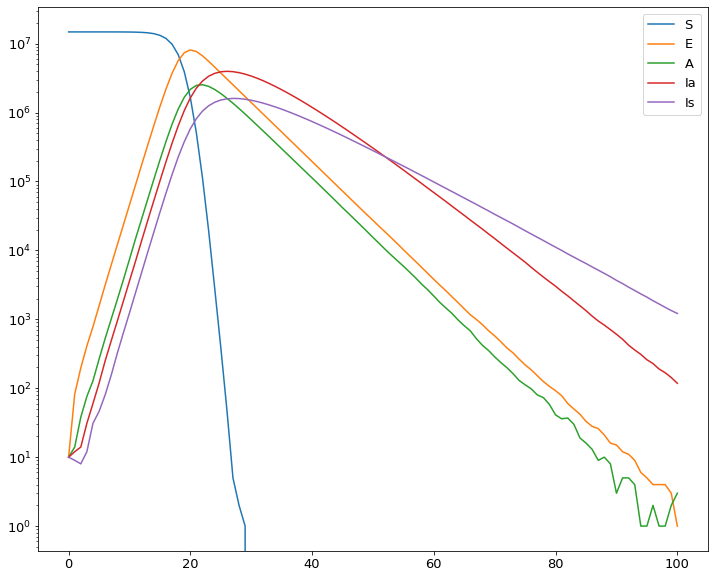

In [59]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')
plt.semilogy()
plt.legend()
plt.show()

## 2) Inference
We take the first $30$ data points of the $I_\mathrm{s}, I_\mathrm{h}, I_\mathrm{c}, I_\mathrm{m}$ trajectory and use it to infer the parameters of the model.

In [279]:
import time 

In [280]:
# load the data and rescale to intensive variables 
Tf_inference = 30 
Nf_inference = Tf_inference + 1 

x = np.load('SEAI5R_latent_traj.npy').astype('float')
x = x[:Nf_inference,:8*M]/N
steps = 101 # number internal integration steps taken


# initialise the estimator 
#estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)
estimator = pyross.inference.SEIR(parameters, M, fi, int(N), steps)

## create filter to distinguish between observable classes
fltr=np.repeat(np.array([False, False, False, False, True, True, True, True]), M)
obs=x[:,fltr]
x0 = x[0]

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

ValueError: cannot reshape array of size 16 into shape (4,2)

In [ ]:
eps = 1e-4 

alpha_g = 0.25          
alpha_std = 0.1
alpha_b = (0.05, 0.5)

beta_g  = 0.06         
beta_std = 0.1
beta_b = (eps, 1)

gIa_g   = 0.13
gIa_std = 0.05 
gIa_b = (eps, 0.5)

gIs_g   = 0.13
gIs_std = 0.05 
gIs_b = (eps, 0.5) 

gE_g    = 0.21 
gE_std = 0.05
gE_b = (0.1, 0.3)

gA_g    = 0.35 
gA_std = 0.05 
gA_b = (0.2, 0.5) 
   

E0_g = (E0+3)/N
E0_std = E0_g
E0_b = [[0.1/N, 100/N]]*M 

A0_g  = (A0+3)/N
A0_std = A0_g
A0_b = [[0.1/N, 100/N]]*M

Ia0_g = (Ia0+0.2)/N 
Ia0_std = [5/N]*M
Ia0_b = [(0.1/N, 100/N)]*M

Is0_g = (Is0+0.1)/N 
Is0_std = [5/N]*M  
Is0_b = [(0.1/N, 100/N)]*M

Ih0_g = (Ih0+0.1)/N 
Ih0_std = [5/N]*M 
Ih0_b = [(0.1/N, 100/N)]*M

Ic0_g = (Ic0+0.1)/N 
Ic0_std = [5/N]*M 
Ic0_b = [(0.1/N, 100/N)]*M

Im0_g = (Im0+0.1)/N 
Im0_std = [5/N]*M 
Im0_b = [(0.1/N, 100/N)]*M

S0_g = (S0-10)/N 
S0_std = E0_std*4 
S0_b = [(1/N, f) for f in fi]



# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)   
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b, 
                   *S0_b, *E0_b, *A0_b, *Ia0_b, *Is0_b, *Ih0_b, *Ic0_b, *Im0_b])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g, 
                   *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0_g, *Ih0_g, *Ic0_g, *Im0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std, 
                 *S0_std, *E0_std, *A0_std, *Ia0_std, *Is0_std, *Ih0_std, *Ic0_std, *Im0_std])
start_time = time.time()
params = estimator.latent_inference(guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    global_max_iter=30, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

In [ ]:
# save the parameters 
np.save('SEAI5R_latent_param.npy', params)

In [ ]:
print('True parameters')
print(parameters)

params = np.load('SEAI5R_latent_param.npy')
best_estimates = estimator.make_params_dict(params)
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0)
print('\n Inferred initial conditons: ') 
print((params[6:]*N).astype('int'))

In [ ]:
# Compare inferred trajectories to true trajectories 
x0 = params[6:]
det_model = pyross.deterministic.SEAI5R(best_estimates, int(M), fi)
estimator.set_params(best_estimates)
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('SEAI5R_latent_traj.npy').astype('float')[:, :8*M]/N

plt.plot(np.sum(x[:,M:4*M], axis=1), label='True unknown infective')
plt.plot(np.sum(x_det[:,M:4*M], axis=1), label='Inferred unknown infective')
plt.plot(np.sum(x[:,4*M:], axis=1), label='True known infectives')
plt.plot(np.sum(x_det[:, 4*M:], axis=1), label='Inferred known infectives')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=12)
plt.show()